In [1]:
import os
import sys
import re
import matplotlib

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from matplotlib      import cm

sys.path.append('../../docs/')

from feynman_equations import representable

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype']  = 42

# Setting the configurations to retrieve processed data

In [7]:
groundtruth_method   = 'SHAP' #['SHAP', 'gradient']
explainers           = ['PE', 'PE_adj', 'SHAP', 'SHAP_adj', 'LIME', 'GINI']
reps                 = 30
normalization_method = 'ExErr' #['ExErr', 'None', 'AbsMax']

# Loading processed data and removing invalid explainers

When we use gradients of the original function as the ground truth, the calculations and adjustments made to Partial Effects explainer with ITEA algorithm doesn't try to approximate the ground truth correctly (due to the adjustment step), so we'll remove them from the plots in order to obtain a clearer visualization. This is also the case for SHAP.

Otherwise, when considering that SHAP is the ground truth, then the PE doesn't try to approximate it correctly (due to the adjustment step), as well as SHAP_adj. So they are removed. 

The cell below does this selection of exlainers.

In [8]:
df_merged = pd.read_csv(f'../../results/tabular_processed/processed_results-{groundtruth_method}-{normalization_method}.csv')

if groundtruth_method == 'gradient':
    
    df_merged = df_merged.drop(
        [c for c in df_merged.columns if re.match(r'^(Global|Local)-(SHAP-|ME_adj-)', c)], axis=1)
elif groundtruth_method == 'SHAP':
    
    df_merged = df_merged.drop(
        [c for c in df_merged.columns if re.match(r'^(Global|Local)-(ME-|SHAP_adj-|LIME-)', c)], axis=1)
    
print(df_merged.columns)

Index(['Dataset', 'Global-PE-ITEA', 'Global-PE_adj-ITEA', 'Global-SHAP-ITEA',
       'Global-SHAP-KR', 'Global-SHAP-RF', 'Global-SHAP-XGB', 'Local-PE-ITEA',
       'Local-PE_adj-ITEA', 'Local-SHAP-ITEA', 'Local-SHAP-KR',
       'Local-SHAP-RF', 'Local-SHAP-XGB', 'RMSE-test-ITEA', 'RMSE-test-KR',
       'RMSE-test-RF', 'RMSE-test-XGB', 'RMSE-train-ITEA', 'RMSE-train-KR',
       'RMSE-train-RF', 'RMSE-train-XGB', 'Tottime-train-ITEA',
       'Tottime-train-KR', 'Tottime-train-RF', 'Tottime-train-XGB'],
      dtype='object')


# Creating boxplots

Local


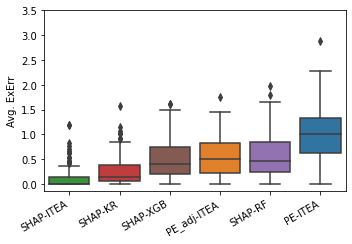

Global


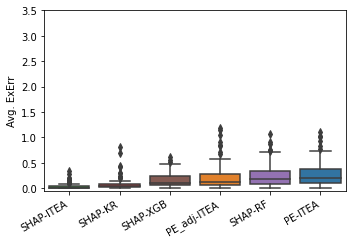

In [9]:
for scope in ['Local', 'Global']:
    print(scope)

    # We are interested only on local and global explanations. RMSE and time will be excluded here
    combinations = np.array([c for c in df_merged.columns if scope in c])

    order = np.argsort(np.mean(df_merged[combinations].values, axis=0))

    fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))

    sns.boxplot(
        x       = "variable",
        y       = "value",
        data    = pd.melt(df_merged[combinations[order]]), ax=ax,
        palette = np.array(sns.color_palette(n_colors=len(combinations)))[order],
        zorder  = 3
    )
    
    #ax.grid(True, axis='y', zorder=-1)
    ax.set_ylim([None, 3.5])
    
    ax.set_xticklabels(
        [l.replace(f'{scope}-', '') for l in combinations[order]],
        rotation = 30,
        ha = 'right'
    )
    
    ax.set_xlabel('')
    ax.set_ylabel(f'Avg. ExErr')
    
    plt.tight_layout()
    
    plt.savefig(f'../../results/figures/{scope}Boxplots-{groundtruth_method}-{normalization_method}.pdf')
    plt.show()

# Aggregating ExErr based on representability

Local, True representable


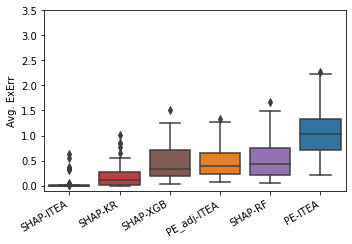

Global, True representable


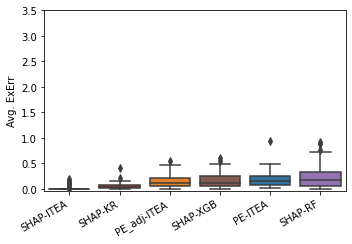

Local, False representable


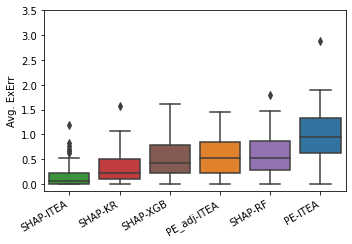

Global, False representable


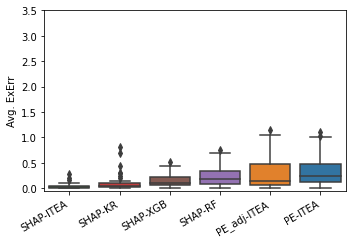

In [10]:
# "representable" contains boolean information about representability of each equation
# by means of the IT representation
for representability in [True, False]:
    for scope in ['Local', 'Global']:
        print(f"{scope}, {representability} representable")

        combinations = np.array([c for c in df_merged.columns if scope in c])
        
        # aditional step to remove some datasets
        filtered = df_merged[
            df_merged['Dataset'].isin([d for d, v in representable.items() if v==representability])
        ]

        order = np.argsort(np.mean(filtered[combinations].values, axis=0))

        fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))

        sns.boxplot(
            x       = "variable",
            y       = "value",
            data    = pd.melt(filtered[combinations[order]]), ax=ax,
            palette = np.array(sns.color_palette(n_colors=len(combinations)))[order],
            zorder  = 3
        )

        #ax.grid(True, axis='y', zorder=-1)
        ax.set_ylim([None, 3.5])

        ax.set_xticklabels(
            [l.replace(f'{scope}-', '') for l in combinations[order]],
            rotation = 30,
            ha = 'right'
        )

        ax.set_xlabel('')
        ax.set_ylabel(f'Avg. ExErr')

        plt.tight_layout()

        plt.savefig(f'../../results/figures/{scope}Boxplots-{groundtruth_method}-{normalization_method}-{representability}Representable.pdf')
        plt.show()